In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966 (90 deg)
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0 (0 deg)
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793 (180 deg)
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

def get_sses_pred(y_test,y_test_pred):
    sse=np.sum((y_test_pred-y_test)**2,axis=0)
    return sse

def get_sses_mean(y_test):
    y_mean=np.mean(y_test,axis=0)
    sse_mean=np.sum((y_test-y_mean)**2,axis=0)
    return sse_mean

def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

def vector_reject(u,v):
    #project u on v, subtract u1 from u
    P = np.outer(v,(v.T))/(v@(v.T))
    u_sub = u - P@u
#     another calculation, to double-check
#     v_norm = np.sqrt(sum(v**2))    
#     proj_u_on_v = (np.dot(u, v)/v_norm**2)*v
#     u_sub = u - proj_u_on_v
    return u_sub

def calc_proj_matrix(A):
    return A@np.linalg.inv(A.T@A)@A.T
def calc_proj(b, A):
    P = calc_proj_matrix(A)
    return P@b.T

# Single Lag

In [2]:
dataset_5ms = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)
dataset_5ms.resample(5)
dataset_5ms.smooth_spk(40, name='smth_40')
bin_width = dataset_5ms.bin_width
print(bin_width)

5


In [3]:
n_dims = 20 # for PCA

active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
passive_mask = (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')


trial_mask = passive_mask
n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_5ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_5ms.data.spikes_smth_40)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

171 trials
65 neurons
(444690, 65)
(444493, 65)
(444690, 20)
PCA total var explained: 0.47354200874916447


In [9]:
def process_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:,:]
    X_test = X[test_set,:,:]
    y_train = y[training_set,:,:]
    y_test = y[test_set,:,:]

    #flat by trials
    X_flat_train = X_train.reshape((X_train.shape[0]*X_train.shape[1]),X_train.shape[2])
    X_flat_test = X_test.reshape((X_test.shape[0]*X_test.shape[1]),X_test.shape[2])
    y_train=y_train.reshape((y_train.shape[0]*y_train.shape[1]),y_train.shape[2])
    y_test=y_test.reshape((y_test.shape[0]*y_test.shape[1]),y_test.shape[2])
    
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)   
    #array with only 0 will have 0 std and cause errors
    X_flat_train_std[X_flat_train_std==0] = 1
    
    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
    y_train_mean=np.mean(y_train,axis=0)
    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean    
    
    return X_flat_train,X_flat_test,y_train,y_test

In [10]:
def fit_and_predict(dataset, trial_mask, align_field, align_range, lag, x_field, y_field):
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]
    
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
    rates_array = rates_df[x_field].to_numpy()
    vel_array = vel_df[y_field].to_numpy()
    lr_all.fit(rates_array, vel_array)
    
    rates_array = rates_array.reshape(n_trials, n_timepoints, n_neurons)
    vel_array = vel_array.reshape(n_trials, n_timepoints, 2)
    
    kf = KFold(n_splits=5,shuffle=True,random_state = 42)   
    true_concat = nans([n_trials*n_timepoints,2])
    pred_concat = nans([n_trials*n_timepoints,2])
    trial_save_idx = 0
    for training_set, test_set in kf.split(range(0,n_trials)):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = process_train_test(rates_array,vel_array,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        
        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2, lr_all.best_estimator_.coef_

In [11]:
def sub_and_predict(dataset, trial_mask, align_field, align_range, lag, x_field, y_field, weights):
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]

    rates_array = rates_df[x_field].to_numpy() - calc_proj(rates_df[x_field].to_numpy(),weights.T).T
    vel_array = vel_df[y_field].to_numpy()
    
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
    lr_all.fit(rates_array, vel_array)
    
    rates_array = rates_array.reshape(n_trials, n_timepoints, n_neurons)
    vel_array = vel_array.reshape(n_trials, n_timepoints, 2)
    
    kf = KFold(n_splits=5,shuffle=True,random_state = 42)   
    true_concat = nans([n_trials*n_timepoints,2])
    pred_concat = nans([n_trials*n_timepoints,2])
    trial_save_idx = 0
    for training_set, test_set in kf.split(range(0,n_trials)):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = process_train_test(rates_array,vel_array,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        
        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2, lr_all.best_estimator_.coef_

## with Neurons

In [12]:
lag_axis = np.arange(-300,300,20)
x_field = 'spikes_smth_40'
y_field ='hand_vel'
trial_mask = passive_mask

R2: -0.3833898828386244
R2: -0.33613118958184374
R2: -0.30649948003955685
R2: -0.33092917518425
R2: -0.37777092502925247
R2: -0.41192725025518384
R2: -0.4559675162276384
R2: -0.46100050880171883
R2: -0.3560434662587717
R2: -0.1494349143581073
R2: 0.1151884476636229
R2: 0.34405020920757934
R2: 0.5262141629538875
R2: 0.6521879250833247
R2: 0.7209534277759491
R2: 0.7406676805624309
R2: 0.7411929221737377
R2: 0.7494433754756084
R2: 0.7597525484282291
R2: 0.6799288120218321
R2: 0.7429922555356874
R2: 0.7391493733419126
R2: 0.7203936214315023
R2: 0.7147706281850628
R2: 0.7200150524814628
R2: 0.7076480339386244
R2: 0.688516530054936
R2: 0.6618053290431192
R2: 0.6237392097793898
R2: 0.5921960411272709


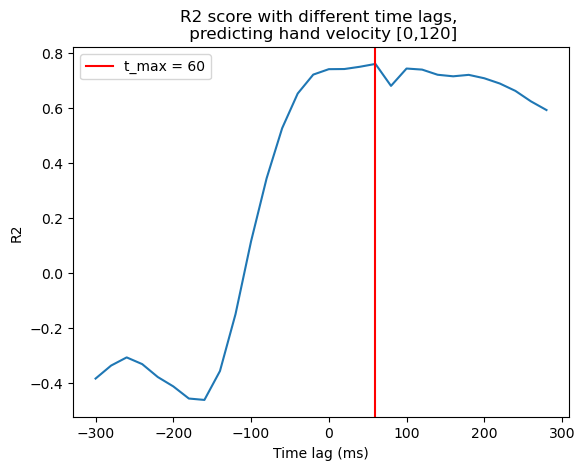

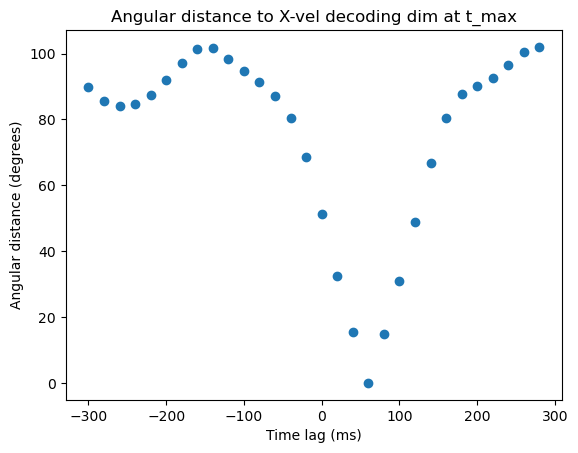

R2: -0.3500905004213286
R2: -0.3113483914837003
R2: -0.28538556899907697
R2: -0.30355478429280547
R2: -0.3483026480470326
R2: -0.38554168885949647
R2: -0.423844224134319
R2: -0.43193704334385585
R2: -0.3627051749128116
R2: -0.1741415049791084
R2: 0.10070232715352112
R2: 0.3406232497564107
R2: 0.5243990870871849
R2: 0.6498740724837055
R2: 0.7147080273795186
R2: 0.7156871472696007
R2: 0.6557993786376819
R2: 0.43002182099927533


KeyboardInterrupt: 

In [14]:
n_timepoints = int((120 - (-0))/dataset_5ms.bin_width)
early_r2_array = nans([len(lag_axis)])
early_coef_array = nans([len(lag_axis),2,n_neurons])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag, x_field, y_field)
    early_r2_array[i] = r2
    early_coef_array[i,:,:] = coef

curr_r2_array = early_r2_array
curr_coef_array = early_coef_array
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [0,120]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()

weights = curr_coef_array[idx_max,:,:]
for iter in range(0,3):  
    #subtract predictions with primary decoding dimensions (at time with max R2)
    sub_coef_array = nans([len(lag_axis),2,n_neurons])
    sub_r2_array = nans([len(lag_axis)])
    if iter != 0:
        weights = np.vstack((weights,curr_coef_array[idx_max,:,:]))
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        r2, coef = sub_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag,x_field,y_field,weights)
        sub_r2_array[i] = r2
        sub_coef_array[i,:,:] = coef

    plt.plot(lag_axis,sub_r2_array)
    plt.title('R2 score projecting out t_max dim')
    idx_max = np.argmax(sub_r2_array)
    time_max = lag_axis[idx_max]
    plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
    plt.legend()
    plt.xlabel('Time lag (ms)')
    plt.ylabel('R2')
    plt.show()

    plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
    plt.axhline(0,color = 'k',linestyle='--')
    plt.title('R2 difference after projecting out t_max dim')
    plt.xlabel('Time lag (ms)')
    plt.ylabel('R2 difference')
    plt.show()

    curr_r2_array = sub_r2_array
    curr_coef_array = sub_coef_array


## with PCA

In [ ]:
x_field = 'PCA'
y_field ='hand_vel'
lag_axis = np.arange(-300,300,20)

In [ ]:
n_timepoints = int((120 - (-0))/dataset_5ms.bin_width)
PCA_early_r2_array = nans([len(lag_axis)])
PCA_early_coef_array = nans([len(lag_axis),2,n_dims])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag, x_field, y_field)
    PCA_early_r2_array[i] = r2
    PCA_early_coef_array[i,:,:] = coef

curr_r2_array = PCA_early_r2_array
curr_coef_array = PCA_early_coef_array
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [0,120]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()

weights = curr_coef_array[idx_max,:,:]
for iter in range(0,3):  
    #subtract predictions with primary decoding dimensions (at time with max R2)
    sub_coef_array = nans([len(lag_axis),2,n_dims])
    sub_r2_array = nans([len(lag_axis)])
    if iter != 0:
        weights = np.vstack((weights,curr_coef_array[idx_max,:,:]))
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        r2, coef = sub_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag,x_field,y_field,weights)
        sub_r2_array[i] = r2
        sub_coef_array[i,:,:] = coef

    plt.plot(lag_axis,sub_r2_array)
    plt.title('R2 score projecting out t_max dim')
    idx_max = np.argmax(sub_r2_array)
    time_max = lag_axis[idx_max]
    plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
    plt.legend()
    plt.xlabel('Time lag (ms)')
    plt.ylabel('R2')
    plt.show()

    plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
    plt.axhline(0,color = 'k',linestyle='--')
    plt.title('R2 difference after projecting out t_max dim')
    plt.xlabel('Time lag (ms)')
    plt.ylabel('R2 difference')
    plt.show()

    curr_r2_array = sub_r2_array
    curr_coef_array = sub_coef_array


# Multi Lags

In [17]:
dataset_50ms = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)
dataset_50ms.resample(50)
print(dataset_50ms.bin_width)

50


In [18]:
n_dims = 20 # for PCA

active_mask = (~dataset_50ms.trial_info.ctr_hold_bump) & (dataset_50ms.trial_info.split != 'none')
passive_mask = (dataset_50ms.trial_info.ctr_hold_bump) & (dataset_50ms.trial_info.split != 'none')


trial_mask = passive_mask
n_trials = dataset_50ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_50ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_50ms.data.spikes)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_50ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

171 trials
65 neurons
(44469, 65)
(44465, 65)
(44469, 20)
PCA total var explained: 0.4025182108228283


In [19]:
passive_data = dataset_50ms.make_trial_data(align_field='move_onset_time', align_range=(-300, 700), ignored_trials=~trial_mask)
for idx, trial in passive_data.groupby('trial_id'):
    n_timepoints = trial.shape[0]
    break
print(n_timepoints,'time bins')

passive_trials_neuron = nans([n_trials,n_timepoints,n_neurons])
passive_trials_vel = nans([n_trials,n_timepoints,2])
passive_trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in passive_data.groupby('trial_id'):
    passive_trials_neuron[i,:,:]=trial.spikes.to_numpy()
    passive_trials_vel[i,:,:]=trial.hand_vel.to_numpy()
    passive_trials_pca[i,:,:]=trial.PCA.to_numpy()
    i+=1
print(passive_trials_neuron.shape)
print(passive_trials_vel.shape)
print(passive_trials_pca.shape)


20 time bins
(171, 20, 65)
(171, 20, 2)
(171, 20, 20)


## with Neurons

In [27]:
data_range = [-300,700]
pred_start = 0
pred_end = 120

idx1 = int((pred_start - data_range[0])/dataset_50ms.bin_width)
idx2 = int(n_timepoints - (data_range[1]-pred_end)/dataset_50ms.bin_width)

t_before_range = range(0,301,50);
t_after_range = range(0,501,50);

whole_multi_R2s = nans([len(t_before_range),len(t_after_range)])
whole_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_neurons])
        i = 0
        for trial_data in passive_trials_neuron:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = passive_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        kf = KFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in kf.split(range(0,n_trials)):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        whole_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',whole_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    whole_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.6789782267429916
Predicting with 0 to 50 ms neural data
R2: 0.7383718563427237
Predicting with 0 to 100 ms neural data
R2: 0.7908687225259099
Predicting with 0 to 150 ms neural data
R2: 0.7955331881664417
Predicting with 0 to 200 ms neural data
R2: 0.8146530896102506
Predicting with 0 to 250 ms neural data
R2: 0.8077994239001758
Predicting with 0 to 300 ms neural data
R2: 0.8143517093276982
Predicting with 0 to 350 ms neural data
R2: 0.8179135392234115
Predicting with 0 to 400 ms neural data
R2: 0.8122184128878958
Predicting with 0 to 450 ms neural data
R2: 0.8193707274824892
Predicting with 0 to 500 ms neural data
R2: 0.8162808766004814
Predicting with -50 to 0 ms neural data
R2: 0.7517817483299201
Predicting with -50 to 50 ms neural data
R2: 0.7906921887250712
Predicting with -50 to 100 ms neural data
R2: 0.832641791667762
Predicting with -50 to 150 ms neural data
R2: 0.8294560001521191
Predicting with -50 to 200 ms neural data
R2: 0.842696

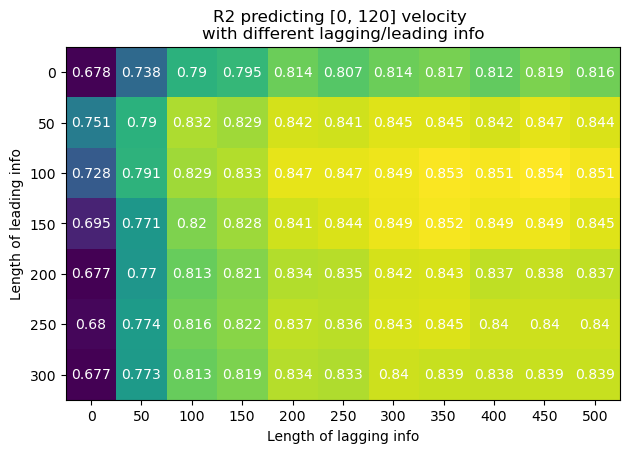

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(whole_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [0, 120] velocity \nwith different lagging/leading info")
fig.tight_layout()
 
for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(whole_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()

## with PCA

In [29]:
PCA_whole_multi_R2s = nans([len(t_before_range),len(t_after_range)])
PCA_whole_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_dims])
        i = 0
        for trial_data in passive_trials_pca:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = passive_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        kf =KFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in kf.split(range(0,n_trials)):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        PCA_whole_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',PCA_whole_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    PCA_whole_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.5622011706073997
Predicting with 0 to 50 ms neural data
R2: 0.6638027366229209
Predicting with 0 to 100 ms neural data
R2: 0.749670859835106
Predicting with 0 to 150 ms neural data
R2: 0.765968493746385
Predicting with 0 to 200 ms neural data
R2: 0.7772180090816999
Predicting with 0 to 250 ms neural data
R2: 0.78046094775863
Predicting with 0 to 300 ms neural data
R2: 0.7770333614337089
Predicting with 0 to 350 ms neural data
R2: 0.7789488291705814
Predicting with 0 to 400 ms neural data
R2: 0.7670389232964925
Predicting with 0 to 450 ms neural data
R2: 0.7562138399044531
Predicting with 0 to 500 ms neural data
R2: 0.7564810705267362
Predicting with -50 to 0 ms neural data
R2: 0.7024201472645988
Predicting with -50 to 50 ms neural data
R2: 0.7479286581628402
Predicting with -50 to 100 ms neural data
R2: 0.8013879094991003
Predicting with -50 to 150 ms neural data
R2: 0.8089227183400742
Predicting with -50 to 200 ms neural data
R2: 0.816239098

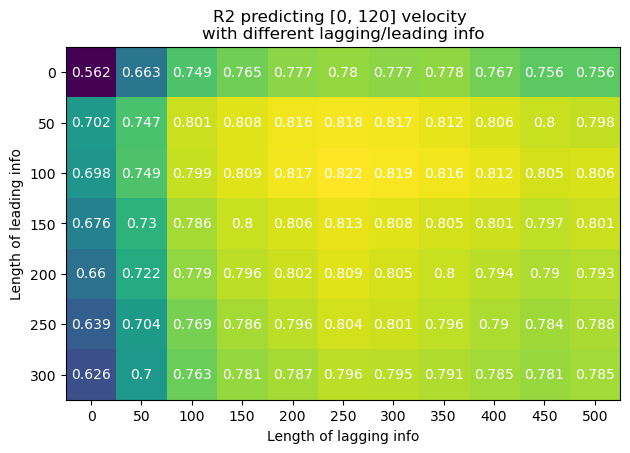

In [30]:
fig, ax = plt.subplots()
im = ax.imshow(PCA_whole_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [0, 120] velocity \nwith different lagging/leading info")
fig.tight_layout()

for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(PCA_whole_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()